<a href="https://colab.research.google.com/github/Osmanoor/Sprites/blob/main/Sprites_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Section 1: Setup and Hyperparameters**

First, we set up the environment. We define the specific hyperparameters used in the course to generate the 16x16 sprites.

In [1]:
!git clone https://github.com/Osmanoor/Sprites.git
%cd Sprites/

Cloning into 'Sprites'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 15 (delta 4), reused 6 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 19.36 MiB | 15.93 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os
from diffusion_utilities import *  # Imports the helper functions you provided
from torch.utils.data import DataLoader # Import DataLoader
from tqdm import tqdm # Import tqdm for progress bars

# Define the device (Use GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
print(f"Using device: {device}")

# --- Hyperparameters ---

# Diffusion hyperparameters
timesteps = 500              # How many steps to add/remove noise
beta1 = 1e-4                 # Start of the noise schedule
beta2 = 0.02                 # End of the noise schedule

# Network hyperparameters
n_feat = 64                  # Hidden dimension feature size
n_cfeat = 5                  # Context vector size (Hero, Non-Hero, Food, Spell, Side-facing)
height = 16                  # Image size (16x16)
save_dir = './weights/'      # Where to save models

# Training hyperparameters
batch_size = 100
n_epoch = 32
lrate = 1e-3

# Create directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Using device: cuda:0


#### **Section 2: The Forward Diffusion Process**

Here we define the **Noise Schedule**. This is the mathematical formula that decides how much noise to add at every timestep $t$.

*   $\beta_t$ (`b_t`): The variance of noise added at step $t$.
*   $\alpha_t$ (`a_t`): $1 - \beta_t$.
*   $\bar{\alpha}_t$ (`ab_t`): The cumulative product of $\alpha$. This allows us to jump directly from a clean image ($x_0$) to a noisy image at any step ($x_t$) without iterating.

In [4]:
# Construct DDPM noise schedule
# We use a linear schedule for beta, increasing from beta1 to beta2
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()
ab_t[0] = 1

def perturb_input(x, t, noise):
    """
    Perturbs an image 'x' to a specific timestep 't' using the noise schedule.
    Formula: sqrt(alpha_bar_t) * x + sqrt(1 - alpha_bar_t) * noise
    """
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

#### **Section 3: The Neural Network (ContextUnet)**

This is the core brain of the operation. We use the helper classes (`ResidualConvBlock`, `UnetUp`, `UnetDown`, `EmbedFC`) from your `diffusion_utilities.py` file to assemble the full U-Net.

**Key Features of this Architecture:**
1.  **Same Output Size:** Input is 16x16, Output is 16x16 (predicting noise).
2.  **Time Embeddings:** We inject the timestep $t$ so the model knows "how noisy" the image currently is.
3.  **Context Embeddings:** We inject information about *what* to generate (e.g., "Hero" vs "Spell").

In [5]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):
        super(ContextUnet, self).__init__()

        # input channels, intermediate features, context features
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # dimensions: [Batch, 64, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # dimensions: [Batch, 128, 4, 4]

        # Bottleneck: map spatial features to a vector
        # self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU()) # Original for 28x28
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU()) # Adjusted for 16x16 input

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            # up-sample
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4),
            nn.GroupNorm(8, 2 * n_feat), # normalize
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps
            nn.GroupNorm(8, n_feat),                # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep

        # Pass the input image through the initial convolutional layer
        x = self.init_conv(x)

        # Pass the result through the down-sampling path
        down1 = self.down1(x)       # [Batch, 64, 8, 8]
        down2 = self.down2(down1)   # [Batch, 128, 4, 4]

        # Convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)

        # Mask out context if context_mask == 1 (or if c is None)
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        # Embed context and timestep
        # We view/reshape them to match the spatial dimensions for broadcasting or concatenation
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # Up-sampling path
        up1 = self.up0(hiddenvec)

        # For up2, we add the embeddings to the output of up1 before feeding into UnetUp
        # This is where the control happens!
        up2 = self.up1(cemb1 * up1 + temb1, down2)  # Add and multiply embeddings
        up3 = self.up2(cemb2 * up2 + temb2, down1)

        # Concatenate with original x (skip connection) and output
        out = self.out(torch.cat((up3, x), 1))
        return out

# Instantiate the model
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)
print(f"Model instantiated. Number of parameters: {sum(p.numel() for p in nn_model.parameters())}")

Model instantiated. Number of parameters: 1480771



Here is the next part of the Unified Notebook.

### **Section 4: The Training Loop**

In this section, we define how the model learns.

**Key Concepts from the Course:**
1.  **Random Time Sampling:** We don't train on just one noise level. For every image in a batch, we pick a random timestep $t$ (e.g., image 1 gets $t=50$, image 2 gets $t=400$).
2.  **Context Masking:** To make the model robust (and capable of generating images without specific instructions), we randomly hide the context label (set it to zero) about 10% of the time during training.
3.  **Objective:** The model tries to predict the **noise** that was added, not the image itself.

*Note: Training this on a CPU takes hours. I have set `train_model = False` by default. If you have the pre-trained weights (`model_trained.pth` or `context_model_trained.pth`) in the `save_dir`, the code will skip training and load them.*

In [9]:
# --- Load Dataset ---
# We assume the files are in the current directory as per the course structure
# You can change these paths if your data is elsewhere
dataset = CustomDataset(
    "./sprites_1788_16x16.npy",
    "./sprite_labels_nc_1788_16x16.npy",
    transform,
    null_context=False
)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

# --- Training Logic ---

train_model = True  # Set to True if you want to train from scratch (takes time!)

if train_model:
    nn_model.train()

    for ep in range(n_epoch):
        print(f'Epoch {ep}')

        # Linearly decay learning rate
        optim.param_groups[0]['lr'] = lrate * (1 - ep / n_epoch)

        # Progress bar
        pbar = tqdm(dataloader, mininterval=2)

        for x, c in pbar:  # x: images, c: context labels
            optim.zero_grad()
            x = x.to(device)
            c = c.to(x)

            # --- Context Masking ---
            # Randomly mask out context to allow unconditional generation
            # Bernoulli(0.9) means 90% chance of keeping context, 10% chance of masking
            context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
            c = c * context_mask.unsqueeze(-1)

            # --- Perturb Data ---
            noise = torch.randn_like(x)
            t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device)
            x_pert = perturb_input(x, t, noise)

            # --- Forward Pass ---
            # Predict the noise in the image
            # We pass t / timesteps to normalize the time input to [0, 1]
            pred_noise = nn_model(x_pert, t / timesteps, c=c)

            # --- Loss Calculation ---
            # Loss is Mean Squared Error between predicted noise and actual noise
            loss = F.mse_loss(pred_noise, noise)
            loss.backward()
            optim.step()

        # Save model periodically
        if ep % 4 == 0 or ep == int(n_epoch - 1):
            torch.save(nn_model.state_dict(), save_dir + f"context_model_{ep}.pth")
            print('Saved model at ' + save_dir + f"context_model_{ep}.pth")

else:
    # Load pre-trained weights if we aren't training
    # Ensure you have the file 'context_model_trained.pth' or similar in weights/
    try:
        # Trying to load the final model from the course materials
        model_path = f"{save_dir}/context_model_trained.pth"
        # If that doesn't exist, try looking for a specific epoch
        if not os.path.exists(model_path):
            model_path = f"{save_dir}/context_model_31.pth"

        nn_model.load_state_dict(torch.load(model_path, map_location=device))
        nn_model.eval()
        print(f"Loaded model weights from {model_path}")
    except FileNotFoundError:
        print("No pre-trained model found. Please set train_model = True to train from scratch.")

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)
Epoch 0


100%|██████████| 894/894 [00:30<00:00, 29.55it/s]


Saved model at ./weights/context_model_0.pth
Epoch 1


100%|██████████| 894/894 [00:28<00:00, 31.06it/s]


Epoch 2


100%|██████████| 894/894 [00:28<00:00, 31.29it/s]


Epoch 3


100%|██████████| 894/894 [00:28<00:00, 31.52it/s]


Epoch 4


100%|██████████| 894/894 [00:28<00:00, 31.39it/s]


Saved model at ./weights/context_model_4.pth
Epoch 5


100%|██████████| 894/894 [00:28<00:00, 31.23it/s]


Epoch 6


100%|██████████| 894/894 [00:28<00:00, 31.74it/s]


Epoch 7


100%|██████████| 894/894 [00:28<00:00, 31.49it/s]


Epoch 8


100%|██████████| 894/894 [00:28<00:00, 30.89it/s]


Saved model at ./weights/context_model_8.pth
Epoch 9


100%|██████████| 894/894 [00:28<00:00, 31.35it/s]


Epoch 10


100%|██████████| 894/894 [00:28<00:00, 31.43it/s]


Epoch 11


100%|██████████| 894/894 [00:29<00:00, 30.76it/s]


Epoch 12


100%|██████████| 894/894 [00:28<00:00, 31.63it/s]


Saved model at ./weights/context_model_12.pth
Epoch 13


100%|██████████| 894/894 [00:28<00:00, 31.37it/s]


Epoch 14


100%|██████████| 894/894 [00:28<00:00, 31.04it/s]


Epoch 15


100%|██████████| 894/894 [00:28<00:00, 31.45it/s]


Epoch 16


100%|██████████| 894/894 [00:28<00:00, 31.53it/s]


Saved model at ./weights/context_model_16.pth
Epoch 17


100%|██████████| 894/894 [00:28<00:00, 31.54it/s]


Epoch 18


100%|██████████| 894/894 [00:28<00:00, 30.88it/s]


Epoch 19


100%|██████████| 894/894 [00:28<00:00, 31.54it/s]


Epoch 20


100%|██████████| 894/894 [00:28<00:00, 31.63it/s]


Saved model at ./weights/context_model_20.pth
Epoch 21


100%|██████████| 894/894 [00:28<00:00, 30.96it/s]


Epoch 22


100%|██████████| 894/894 [00:28<00:00, 31.59it/s]


Epoch 23


100%|██████████| 894/894 [00:28<00:00, 31.60it/s]


Epoch 24


100%|██████████| 894/894 [00:28<00:00, 31.26it/s]


Saved model at ./weights/context_model_24.pth
Epoch 25


100%|██████████| 894/894 [00:28<00:00, 31.48it/s]


Epoch 26


100%|██████████| 894/894 [00:28<00:00, 31.62it/s]


Epoch 27


100%|██████████| 894/894 [00:28<00:00, 31.87it/s]


Epoch 28


100%|██████████| 894/894 [00:28<00:00, 31.15it/s]


Saved model at ./weights/context_model_28.pth
Epoch 29


100%|██████████| 894/894 [00:28<00:00, 31.60it/s]


Epoch 30


100%|██████████| 894/894 [00:28<00:00, 31.56it/s]


Epoch 31


100%|██████████| 894/894 [00:28<00:00, 31.12it/s]

Saved model at ./weights/context_model_31.pth


### **Section 5: Standard Sampling (DDPM)**

Now we use the trained brain to hallucinate sprites. This is the **Reverse Diffusion Process**.

**The Math of "Denoise & Add Noise":**
We want to move from noisy $x_t$ to slightly cleaner $x_{t-1}$.
1.  **Subtract Prediction:** We use the neural network to remove the predicted noise.
2.  **Add Noise Back ($z$):** As explained, if we just subtract, the images collapse into generic "blobs." We must add a tiny bit of random noise back (scaled by $\sigma_t$) to maintain texture and variety, effectively "shaking" the image into the correct distribution.

In [10]:
# Helper function: removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)

    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

# Standard Sampling Algorithm (DDPM)
@torch.no_grad()
def sample_ddpm(n_sample, context, save_rate=20):
    # 1. Start with pure noise x_T ~ N(0, 1)
    samples = torch.randn(n_sample, 3, height, height).to(device)

    # Array to keep track of generated steps for plotting/animation
    intermediate = []

    # 2. Iterate backwards from T to 1
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # Reshape time tensor for the model
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # Sample some random noise to inject back in (z)
        # For the very last step (i=1), we don't add noise back (z=0) because we want a clean image
        z = torch.randn_like(samples) if i > 1 else 0

        # 3. Predict noise using the UNet
        eps = nn_model(samples, t, c=context)

        # 4. Update samples using the denoise function
        samples = denoise_add_noise(samples, i, eps, z)

        # Save intermediate images for visualization
        if i % save_rate == 0 or i == timesteps or i < 8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

### **Visualization**

Let's verify it works by generating samples with random contexts.


In [11]:
# Visualize samples with randomly selected context
plt.clf()

# Create random context vectors (batch of 32)
# randint(0, 5) picks a category, F.one_hot makes it a vector
ctx = F.one_hot(torch.randint(0, 5, (32,)), 5).to(device=device).float()

# Run sampling
samples, intermediate = sample_ddpm(32, ctx)

# Create animation
animation_ddpm = plot_sample(intermediate, 32, 4, save_dir, "ani_run", None, save=False)

# Display in Jupyter (if running in a notebook)
from IPython.display import HTML
HTML(animation_ddpm.to_jshtml())

<Figure size 640x480 with 0 Axes>

### **Section 6: Contextual Control (The "Avocado Armchair")**

Now that the model is trained (or weights loaded), we can control what it generates.

**How it works:**
The model learned 5 specific categories (Hero, Non-Human, Food, Spell, Side-facing). We can pass a **One-Hot Vector** (e.g., `[1, 0, 0, 0, 0]`) to force a specific type.
But we can also pass **Mixed Vectors** (e.g., `[0.5, 0, 0.5, 0, 0]`) to create hybrids.

Generating strict categories...


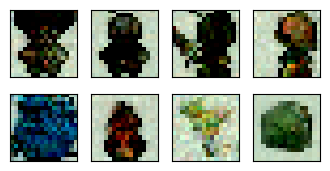

Generating mixed concepts...


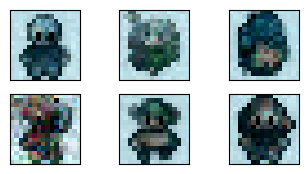

In [12]:
# Helper function to visualize a grid of images nicely
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
    plt.show()

# --- 1. User Defined Context (Strict Categories) ---
print("Generating strict categories...")

# Define context manually:
# 0: Hero, 1: Non-hero, 2: Food, 3: Spell, 4: Side-facing
ctx = torch.tensor([
    [1,0,0,0,0],  # Hero
    [1,0,0,0,0],  # Hero
    [0,0,0,0,1],  # Side-facing
    [0,0,0,0,1],  # Side-facing
    [0,1,0,0,0],  # Non-Hero
    [0,1,0,0,0],  # Non-Hero
    [0,0,1,0,0],  # Food
    [0,0,1,0,0],  # Food
]).float().to(device)

# Sample using standard DDPM
samples, _ = sample_ddpm(ctx.shape[0], ctx)
show_images(samples)

# --- 2. Mixing Context (The "Avocado Armchair" Effect) ---
print("Generating mixed concepts...")

ctx = torch.tensor([
    [1,0,0,0,0],      # Pure Human
    [1,0,0.6,0,0],    # Human + Food (Edible Hero?)
    [0,0,0.6,0.4,0],  # Food + Spell (Magic Potion?)
    [1,0,0,0,1],      # Human + Side-facing
    [1,1,0,0,0],      # Human + Non-Human (Hybrid Monster)
    [1,0,0,1,0]       # Human + Spell (Wizard)
]).float().to(device)

samples, _ = sample_ddpm(ctx.shape[0], ctx)
show_images(samples)

### **Section 7: Fast Sampling (DDIM)**

Standard DDPM takes 500 steps. That's slow.
**DDIM (Denoising Diffusion Implicit Models)** is a deterministic algorithm that allows us to skip steps. We can generate a good image in just **20 steps**.

**The Math Difference:**
DDIM doesn't add random noise $z$ at every step. Instead, it looks at the current noisy image, predicts the final clean image $x_0$, and then points the direction to the *next* noisy step $x_{t-1}$.

In [13]:
# --- Define DDIM Sampling Function ---

def denoise_ddim(x, t, t_prev, pred_noise):
    """
    DDIM Step: Removes noise deterministically to jump from step t to step t_prev.
    """
    ab = ab_t[t]
    ab_prev = ab_t[t_prev]

    # 1. Predict the final clean image (x0) based on current prediction
    x0_pred = ab_prev.sqrt() / ab.sqrt() * (x - (1 - ab).sqrt() * pred_noise)

    # 2. Determine the direction pointing to x_t
    dir_xt = (1 - ab_prev).sqrt() * pred_noise

    # 3. Combine to get x_{t-1}
    return x0_pred + dir_xt

@torch.no_grad()
def sample_ddim(n_sample, context, n=20):
    """
    Fast Sampling.
    n: Number of steps to actually take (e.g., 20 instead of 500)
    """
    # Start with pure noise
    samples = torch.randn(n_sample, 3, height, height).to(device)

    intermediate = []

    # Calculate step size (e.g., 500 // 20 = 25 steps per jump)
    step_size = timesteps // n

    # Iterate backwards, skipping steps
    for i in range(timesteps, 0, -step_size):
        print(f'DDIM sampling timestep {i:3d}', end='\r')

        # Create time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # Predict noise
        eps = nn_model(samples, t, c=context)

        # Denoise using DDIM formula
        # We jump from i -> i - step_size
        samples = denoise_ddim(samples, i, i - step_size, eps)

        intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

### **Comparison & Benchmark**

Finally, let's verify the speedup on your T4 GPU. We will generate 32 images using both methods and time them.


--- Benchmarking Speed ---
sampling timestep   1
DDPM (500 steps) time: 3.13 seconds
DDIM sampling timestep  25
DDIM (20 steps) time:  0.10 seconds

Speedup Factor: 31.87x faster!

Visualizing DDIM output:


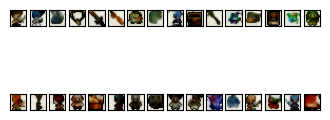

In [14]:
import time

# Create a random context for the benchmark
ctx = F.one_hot(torch.randint(0, 5, (32,)), 5).to(device=device).float()

print("\n--- Benchmarking Speed ---")

# 1. Time DDPM (500 Steps)
start_time = time.time()
sample_ddpm(32, ctx)
ddpm_time = time.time() - start_time
print(f"\nDDPM (500 steps) time: {ddpm_time:.2f} seconds")

# 2. Time DDIM (20 Steps)
start_time = time.time()
sample_ddim(32, ctx, n=20)
ddim_time = time.time() - start_time
print(f"\nDDIM (20 steps) time:  {ddim_time:.2f} seconds")

print(f"\nSpeedup Factor: {ddpm_time / ddim_time:.2f}x faster!")

# Visual Check of DDIM Quality
print("\nVisualizing DDIM output:")
samples, _ = sample_ddim(32, ctx, n=20)
show_images(samples)